In [1]:
#default_exp anime.dataloader

In [2]:
#have to update this so often just going to do it every run
!pip install wandb --upgrade

Requirement already up-to-date: wandb in /home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages (0.8.25)


In [3]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fast.torch_basics import *
from fast.layers import *
from fast.data.all import *
from fast.data.block import *
from fast.optimizer import *
from fast.learner import *
from fast.metrics import *
from fast.callback.all import *
from fast.vision.all import *
from anime.ugatit import *
from fast.callback.wandb import WandbCallback
from anime.kid import *
import wandb
from fast.fp16_utils import convert_module
from UGATIT import ILN,adaILN
from fast.callback.fp16 import _copy_state
import gc
#from fast.callback.tensorboard import TensorBoardCallback

In [4]:
# True = use GPU
defaults.use_cuda=True 
path=Path("/home/fast/.fastai/data/danbooru2018")
meta_path=path/'metadata/2018000000000016'
portraits=pd.read_pickle(path/'portraits')
selfie_path=Path('/home/fast/.fastai/data/Selfie-dataset')
self_txt= selfie_path/'selfie_dataset.txt'
self_txt.exists()
attrs='image_name popularity partial_faces is_female baby child teenager youth middle_age senior white black asian oval_face round_face heart_face smiling mouth_open frowning wearing_glasses wearing_sunglasses wearing_lipstick tongue_out duck_face black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair showing_cellphone using_earphone using_mirror braces wearing_hat harsh_lighting dim_lighting'.split()
img_size=512 #needs to be >96 oherwise loss is nan

In [5]:
lr=0.0001
wd=0.0001

## Tag comparison

In [6]:
def getSelfiePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/((dft['image_name']).values[0]+'.jpg')
    return (dft.values,path)
def getImagePath(df,dir,i):
    dft=df.iloc[[i]]
    path=dir/'512px'/(dft['directory']+'/'+dft['file']).values[0]
    return (dft.tags.values[0],path)

In [7]:
class DSList():
    def __init__(self,name='selfie2anime'):
        self.name=name
    def __call__(self):
        if(self.name=='selfie2anime'):
            return self._selfie2anime()
        elif(self.name=='_danbooru'):
            return self._danbooru()
    def _danbooru(self):
        def txt_to_path(img,dir=dir,ext='.jpg'):
            return dir/(img+ext)
        selfies=pd.read_pickle(selfie_path/'selfies')
        selfie_imgs=L(list(selfies['image_name'].apply(partial(txt_to_path,dir=selfie_path/'images'))))
        f=partial(txt_to_path,dir=path/'512px',ext='')
        locs=portraits['directory']+'/'+portraits['file']
        anime_imgs=L(list(locs.apply(f)))
        return selfie_imgs,anime_imgs
    def _selfie2anime(self):
        selfie_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainA").ls())
        anime_imgs=L(Path("/home/fast/.fastai/data/selfie2anime/trainB").ls())
        return selfie_imgs,anime_imgs
selfie_imgs,anime_imgs=DSList()()
len(anime_imgs),len(selfie_imgs)

(3400, 3400)

In [8]:
tfms = [PILImage.create]
ds_img_tfms = [ToTensor()]

In [9]:
class CycleImage(Tuple):
    def toTensor(self):
        img1,img2 = self
        return torch.cat([img1,img2], dim=2)
    def show(self, ctx=None, **kwargs): 
        return show_image(self.toTensor(),  ctx=ctx)

In [10]:
class CyclePair(Transform):
    def __init__(self,bItems):
        self.small = bItems #(aItems,bItems) if len(aItems)>len(bItems) else (bItems,aItems)
        self.assoc = self
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        return CycleImage(i, random.choice(self.small)) #CycleImage(self.large[i], random.choice(self.small))

In [11]:
class ToTensorTuple(TupleTransform):
    "Convert item to appropriate tensor class"
    order = 15
@ToTensorTuple
def encodes(self, o:CycleImage): return TensorImage(image2byte(o))

In [12]:
data_stats={'selfie_means':torch.Tensor([143.81911227601947, 119.46716940677527, 113.92494676532168]),
 'selfie_stds':torch.Tensor([67.72407215465199, 64.41496156519109, 52.516515323610015]),
 'anime_means':torch.Tensor([173.24273681640625, 155.69161987304688, 135.62557983398438]),
 'anime_stds':torch.Tensor([51.790767669677734, 48.620208740234375, 48.380496978759766])}
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        x=tensor(x).permute(2,0,1).float()
    elif x.ndim==2:
        x=tensor(x)[None].repeat(3,1,1).float()
    if(fn.parent.name=='trainA'):
        return (x-data_stats['selfie_means'][:,None][:,None])/data_stats['selfie_stds'][:,None][:,None]
    elif(fn.parent.name=='trainB'):
        return (x-data_stats['anime_means'][:,None][:,None])/data_stats['anime_stds'][:,None][:,None]
    raise ValueError('The path was not expected '+str(fn))
#OpenAndResize = TupleTransform(partial(resized_image,sz=img_size))

In [13]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        return tensor(x).permute(2,0,1).float()/255.
    elif x.ndim==2:
        return tensor(x)[None].repeat(3,1,1).float()/255.
OpenAndResize = TupleTransform(partial(resized_image,sz=img_size))

In [14]:
tm=[CyclePair(anime_imgs), OpenAndResize, IntToFloatTensor(div=False)]#+[ToTensorTuple(),]

In [15]:
to_float??

In [16]:
class Half(Transform):
    "Move batch to `device` (defaults to `default_device()`)"
    def __init__(self,dtype=torch.half):
        self.dtype=dtype
        super().__init__(split_idx=None, as_item=False)
    def encodes(self, b): return to_half(b)
    def decodes(self, b): return to_float(b)

    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [17]:
#Half(),
after_batch=[Half(),Cuda()]#Cuda(),#+aug_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1, max_lighting=0.2,
                   #max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None,
                   #size=None, mode='bilinear', pad_mode=PadMode.Reflection)
tfm=Pipeline(tm, as_item=False) #+after_batch

In [18]:
class NoopTensor(Transform):
    def encodes(self, x): return CycleImage(torch.Tensor([[[0]]]),torch.Tensor([[[0]]])) #needs to match output of network type

In [19]:
tfm2=Pipeline([NoopTensor()],as_item=False)

In [20]:
val_path=selfie_imgs[0].parent
val = ['female_10686.jpg',
 'female_10367.jpg',
 'female_30988.jpg',
 'female_8194.jpg',
 'female_18724.jpg',
 'female_10087.jpg',
 'female_27647.jpg',
 'female_13409.jpg',
 'female_20608.jpg',
 'female_26279.jpg',
 'female_7103.jpg',
 'female_10615.jpg',
 'female_25884.jpg',
 'female_31235.jpg',
 'female_28991.jpg',
 'female_9936.jpg',
 'female_33285.jpg',
 'female_33491.jpg',
 'female_1597.jpg',
 'female_13893.jpg',
 'female_26481.jpg',
 'female_32384.jpg',
 'female_18827.jpg',
 'female_19176.jpg',
 'female_6150.jpg',
 'female_1487.jpg',
 'female_13914.jpg',
 'female_29264.jpg',
 'female_17571.jpg',
 'female_32817.jpg',
 'female_7374.jpg',
 'female_16798.jpg',
 'female_21739.jpg',
 'female_22605.jpg',
 'female_21305.jpg',
 'female_12988.jpg',
 'female_4297.jpg',
 'female_9025.jpg',
 'female_13560.jpg',
 'female_31712.jpg',
 'female_1177.jpg',
 'female_13787.jpg',
 'female_11117.jpg',
 'female_10664.jpg',
 'female_17134.jpg',
 'female_16420.jpg',
 'female_95.jpg',
 'female_15298.jpg',
 'female_32776.jpg',
 'female_9353.jpg',
 'female_22181.jpg',
 'female_32015.jpg',
 'female_27565.jpg',
 'female_19001.jpg',
 'female_8955.jpg',
 'female_33094.jpg',
 'female_7486.jpg',
 'female_32167.jpg',
 'female_28716.jpg',
 'female_6519.jpg',
 'female_4339.jpg',
 'female_24557.jpg',
 'female_20786.jpg',
 'female_26695.jpg',
 'female_25546.jpg',
 'female_15424.jpg',
 'female_711.jpg',
 'female_31004.jpg',
 'female_9440.jpg',
 'female_22912.jpg',
 'female_2754.jpg',
 'female_24839.jpg',
 'female_12741.jpg',
 'female_9480.jpg',
 'female_15677.jpg',
 'female_23557.jpg',
 'female_3006.jpg',
 'female_29858.jpg',
 'female_8664.jpg',
 'female_16808.jpg',
 'female_32694.jpg',
 'female_5019.jpg',
 'female_15584.jpg',
 'female_32256.jpg',
 'female_5747.jpg',
 'female_22101.jpg',
 'female_4115.jpg',
 'female_20185.jpg',
 'female_25131.jpg',
 'female_31061.jpg',
 'female_2546.jpg',
 'female_30868.jpg',
 'female_17341.jpg',
 'female_9415.jpg',
 'female_14142.jpg',
 'female_11470.jpg',
 'female_683.jpg',
 'female_3433.jpg',
 'female_19286.jpg',
 'female_30070.jpg']

In [21]:
selfieL=0
selfieL=len(selfie_imgs)-100 if selfieL<3 or selfieL>len(selfie_imgs)-100 else selfieL
selfie_sample=selfie_imgs.filter(lambda s:s.name in val,negate=True)
selfie_sample=selfie_sample.shuffle()[0:selfieL]
selfie_sample=selfie_sample+map(lambda v:val_path/v,val)
#val_size=100#20 if selfieL>24 else selfieL//2
#val=selfie_sample[0:val_size] set above
tfmDs=DataSource(selfie_sample,[tfm,tfm2],splits=[[selfie.name not in val for selfie in selfie_sample],[selfie.name in val for selfie in selfie_sample]])

In [22]:
dl=TfmdDL(tfmDs,bs=4, shuffle=False, num_workers=8,after_batch=after_batch)

In [23]:
db=dl.databunch(bs=4,val_bs=1,after_batch=after_batch)
# DataBunch(dl) testing above

In [24]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    for i in range_of(samples[0]):
        [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    return ctxs

In [25]:
#selfie_stds=[selfie[0][0].std() for selfie in iter(dl)]
#anime_stds=[anime[0][1].std() for anime in iter(dl)]
#sum(selfie_stds)/len(selfie_stds),sum(anime_stds)/len(anime_stds)

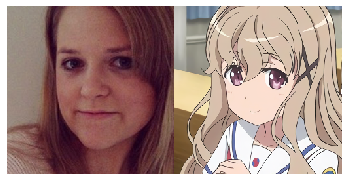

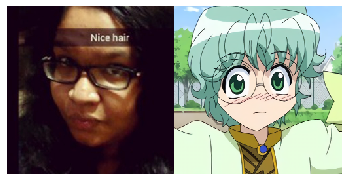

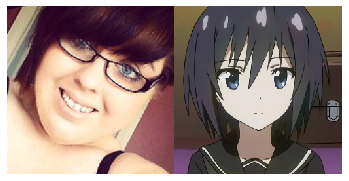

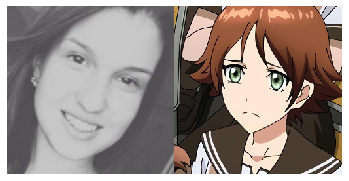

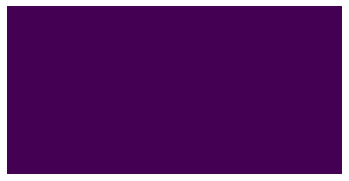

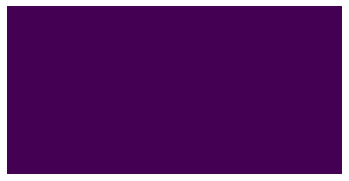

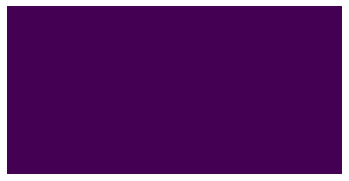

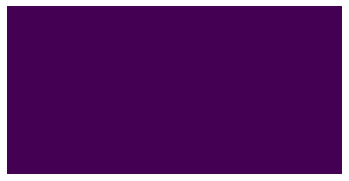

In [26]:
#import pdb; pdb.set_trace()
dl.show_batch()

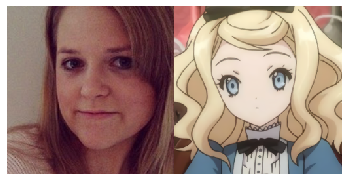

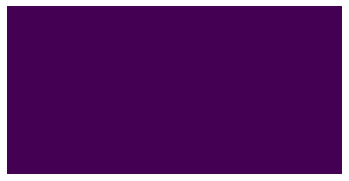

In [27]:
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[0][1][0]).show()
CycleImage(dl._pre_show_batch(dl.one_batch(), max_n=9)[1][0][0],dl._pre_show_batch(dl.one_batch(), max_n=9)[1][1][0]).show()

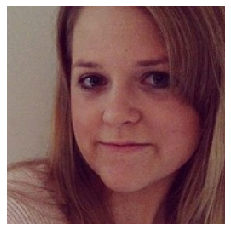

In [28]:
show_image(dl._pre_show_batch(dl.one_batch(), max_n=9)[0][0][0])

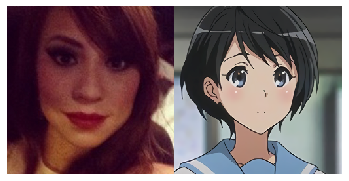

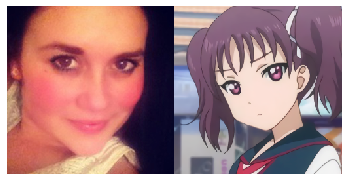

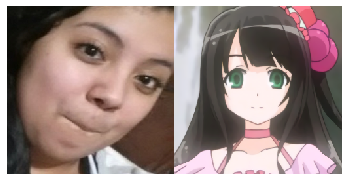

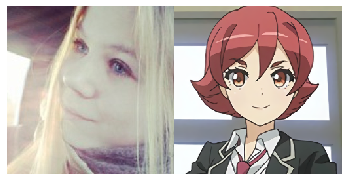

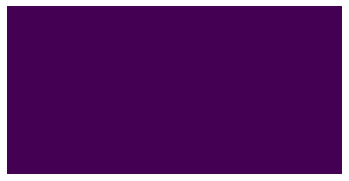

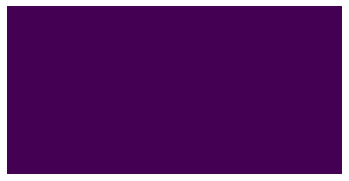

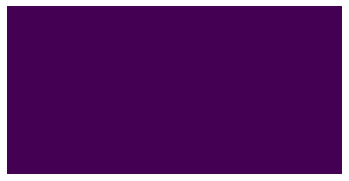

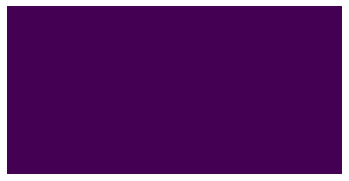

In [29]:
db.show_batch()

In [30]:
ugatit=UGATIT()
ugatit.img_size=img_size
ugatit.build_model()

In [31]:
learner.create_opt??

Object `learner.create_opt` not found.


In [32]:
noop_loss = lambda x: torch.FloatTensor([0])

In [33]:
class GANOptimizer(object):
    def __init__(self, gen_optim,disc_optim,params,lr,wd=0.01):
        gen_params,disc_params=params
        #might want to try lower lr for the generator
        self.gen_optim,self.disc_optim=gen_optim(gen_params,lr=lr,wd=wd),disc_optim(disc_params,lr=lr,wd=wd)
        self.optimizing_gen=True
    def __getattr__(self, item):
        opt= self.gen_optim if(self.optimizing_gen) else self.disc_optim
        return getattr(opt, item)
    def zero_grad(self):
        self.gen_optim.zero_grad()
        self.disc_optim.zero_grad()
    def state_dict(self):
        gs = self.gen_optim.state_dict()
        ds = self.disc_optim.state_dict()
        return {'hypers':{
                    'gen':gs['hypers'],
                    'disc':ds['hypers']},
                'state':{
                    'gen':gs['state'],
                    'disc':ds['state']}}
    def load_state_dict(self, sdict):
        self.gen_optim.load_state_dict({'hypers': sdict['param_groups']['gen'],'state':sdict['state']['gen']})
        self.disc_optim.load_state_dict({'param_groups': sdict['param_groups']['disc'],'state':sdict['state']['disc']})
        
#TODO unable to run one_batch twice without two after_batch calls
#TODO discriminator probably doesn't need gradients from generator, check cycle gan code/paper
class Switch(Callback):
    toward_end=True
    def begin_epoch(self):
        self.learn.disc_pass=False #TODO too many (not disc_pass), switch to gen_pass?!?
        self.model.optimizing_gen= not self.learn.disc_pass
        if(hasattr(self, 'gan_losses')):
            self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        self.opt.zero_grad()
    def begin_batch(self):
        if(not hasattr(self, 'gan_losses')):
            self.gan_losses=self.loss_func
            self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        self.opt.zero_grad()
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
    def after_batch(self):
        if(getattr(self.learn,'overflow',False)):
            self.learn.overflow=False
            if(self.learn.disc_pass):
                self.one_batch(self.iter,self.learn.dbunch.train_dl.one_batch())
            return
        self._switch()
        
    def after_epoch(self):
        self.loss_func=self.gan_losses
    
    def _switch(self):
        if(self.learn.training): self.learn.disc_pass=not self.learn.disc_pass
        self.model.optimizing_gen= not self.learn.disc_pass
        self.opt.optimizing_gen= not self.learn.disc_pass
        self.opt.zero_grad()
        self.learn.loss_func=self.gan_losses[self.learn.disc_pass]
        if(self.learn.disc_pass):
            self.one_batch(self.iter,L(self.xb+self.yb))
        
class RhoClipper(Callback):
    run_after=Switch
    toward_end=True
    def after_batch(self):
        self.model.models['GA2B'].apply(ugatit.Rho_clipper)
        self.model.models['GB2A'].apply(ugatit.Rho_clipper)
class PrintLoss(Callback):
    def after_loss(self):
        if(self.iter%100==0):    
            print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            if(self.learn.disc_pass):
                print('loss Disc: '+str(self.loss.item()))
            else:
                print('loss Gen: '+str(self.loss.item()))
    def begin_batch(self):
        if(self.iter%100==0):
            print('begin batch - batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())
    def after_pred(self):
        if(self.iter%100==0):
            print('after pred- batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())
    def after_backward(self):
        if(self.iter%100==0):
            print('batch: #'+str(self.iter)+'/'+str(self.n_iter)+'/'+str(self.epoch))
            print('memory_allocated()',torch.cuda.memory_allocated())
            print('max_memory_allocated()',torch.cuda.max_memory_allocated())

            for obj in gc.get_objects():
                try:
                    if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                        if obj.device==default_device() and obj.dtype==torch.float:
                            print(type(obj), obj.size(), obj.device, obj.dtype)
                except:
                    pass
class LinearDecreaseLR(Callback):
    def __init__(self,start_epoch=0,end_epoch=None):
        store_attr(self,"start_epoch,end_epoch")
    def begin_fit(self):
        self.max_lr=self.lr
    def end_fit(self):
        self.lr=self.max_lr
    def begin_batch(self):
        end_epoch = self.end_epoch if(self.end_epoch) else self.n_epoch
        current_iter=(self.epoch+self.start_epoch)*self.n_iter+self.iter
        run_length=end_epoch*self.n_iter
        half_run=run_length // 2
        self.lr=self.max_lr
        if current_iter > half_run:
            self.lr = (run_length-current_iter)*self.max_lr/(run_length-half_run)
        elif current_iter < half_run/2:
            self.lr = self.max_lr*(current_iter+1)/(half_run/2+1)
        else:
            self.lr = self.max_lr
        self.opt.set_hyper('lr',self.lr)
        
class SameXbYb(Callback):
    def after_pred(self):
        self.learn.yb=self.learn.xb

In [34]:
#@typedispatch
#def tensorboard_log(x:CycleImage, y: CycleImage, samples, outs, writer, step):
#    fig,axs = get_grid(len(samples), add_vert=1, return_fig=True, double=True)
#    for i in range(2):
#        axs[::2] = [b.show(ctx=c) for b,c in zip(samples.itemgot(i),axs[::2])]
#    for x in [samples,outs]:
#        axs[1::2] = [b.show(ctx=c) for b,c in zip(x.itemgot(0),axs[1::2])]
#    writer.add_figure('Sample Results', fig, step)

In [35]:
@typedispatch
def wandb_process(x:CycleImage, y:CycleImage, samples, outs):
    "Process `sample` and `out` depending on the type of `x/y`"
    res = []
    for s,o in zip(samples, outs):
        img = TensorImage(s[0].toTensor()[0])
        #db.valid_dl.decode(s)
        res.append(wandb.Image(img, caption='Input data', grouping=3))
        for t, capt in ((o[0], "Prediction"), (s[1], "Ground Truth")):
            # Resize plot to image resolution (from https://stackoverflow.com/a/13714915)
            my_dpi = 100
            fig = plt.figure(frameon=False, dpi=my_dpi)
            h, w = img.shape[:2]
            fig.set_size_inches(w / my_dpi, h / my_dpi)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            # Superimpose label or prediction to input image
            ax = img.show(ctx=ax)
            #import pdb; pdb.set_trace()
            ax = t.show(ctx=ax)
            res.append(wandb.Image(fig, caption=capt))
            plt.close(fig)
    return res

In [36]:
#logs=Path('/home/fast/.fastai/'+'tensorboard')

In [37]:
wandb.init()

W&B Run: https://app.wandb.ai/marii/uncategorized/runs/07ljdgtr

In [38]:
class MetricRecorder(Callback):
#    def __init__(self, add_time=True, train_metrics=False, beta=0.98):
#        super(MetricRecorder,self).__init__(add_time,train_metrics,beta)
    def after_batch(self):
        mets = self.learn.recorder._train_mets if self.training else self.learn.recorder._valid_mets
        self.learn.metric_values=dict([(met.name, met.value) for met in mets])
#    @property
#    def name(self):
#        return 'recorder'

In [39]:
class Conditional_Loss(AvgSmoothLoss):
    def __init__(self, f=lambda x:True,name='None',beta=0.98,): 
        super(Conditional_Loss,self).__init__(beta)
        self.f=f
        self.metric_name=name
    def accumulate(self, learn):
        if(self.f(learn)):
            super().accumulate(learn)
            
            setattr(learn, self.metric_name, self.value)
    @property
    def name(self):
        return self.metric_name

In [40]:
#https://github.com/NVIDIA/apex/blob/03a25ba8a61d15a503405ef4bbda83724bb531b2/apex/fp16_utils/fp16util.py
# had to edit due to custom normalization layers
def convert_module_alt(module, dtype):
    """
    Converts a module's immediate parameters and buffers to dtype.
    """
    for param in module.parameters(recurse=False):
        if param is not None:
            if param.data.dtype.is_floating_point:
                param.data = param.data.to(dtype=dtype)
            if param._grad is not None and param._grad.data.dtype.is_floating_point:
                param._grad.data = param._grad.data.to(dtype=dtype)
    spectral_norm_buffers=filter(lambda b:b[0] in ('weight_u','weight_v','weight_orig'),module.named_buffers(recurse=False))
    spectral_norm_buffers=list(map(lambda b: b[1],spectral_norm_buffers))
    spectral_norm_buffers=[]
    for buf in module.buffers(recurse=False):
        if buf is not None and buf.data.dtype.is_floating_point and 0==len(list(filter(lambda b:b.shape==buf.shape and torch.all(torch.eq(b, buf)),spectral_norm_buffers))):
            buf.data = buf.data.to(dtype=dtype)
def convert_network(network, dtype):
    """
    Converts a network's parameters and buffers to dtype.
    """
    for module in network.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm) and module.affine is True:
            continue
        if isinstance(module, (ILN,adaILN,nn.InstanceNorm2d,nn.LayerNorm)):
            continue
        convert_module_alt(module, dtype)
        if isinstance(module, torch.nn.RNNBase) or isinstance(module, torch.nn.modules.rnn.RNNBase):
            module.flatten_parameters()
    return network

In [41]:
def multi_model_params(models):
    ps=[]
    for m in models:
        ps+=[p for p in m.parameters() if p.requires_grad]
    return ps
def GAN_splitter(model):
    gen_params=itertools.chain(model.models['GA2B'].parameters(),model.models['GB2A'].parameters())
    disc_params=itertools.chain(model.models['DA'].parameters(),model.models['DB'].parameters(),model.models['LA'].parameters(),model.models['LB'].parameters())
    return (gen_params,disc_params)
class GANWandb(WandbCallback):
    run_before=Switch
    def after_batch(self):
        "Log hyper-parameters and training loss"
        g_scale,d_scale = (self.learn.mixed_precision_tuple.gloss_scale,self.learn.mixed_precision_tuple.dloss_scale) if(hasattr(self.learn,'mixed_precision_tuple')) else (1,1)
        if self.training and not self.learn.disc_pass:
            self._wandb_step += 1
            self._wandb_epoch += 1/self.n_iter
            hypers = {f'{k}G_{i}':v for i,h in enumerate(self.opt.hypers) for k,v in h.items()}
            wandb.log({'epoch': self._wandb_epoch,'loss': self.smooth_loss, **hypers, **self.learn.metric_values, 'loss_scaleG': g_scale}, step=self._wandb_step)
        elif self.training and self.learn.disc_pass:
            hypers = {f'{k}D_{i}':v for i,h in enumerate(self.opt.hypers) for k,v in h.items()}
            wandb.log({'epoch': self._wandb_epoch,'loss': self.smooth_loss, **hypers, **self.learn.metric_values, 'loss_scaleD': d_scale}, step=self._wandb_step)
#   def after_epoch(self):
#        "Log validation loss and custom metrics & log prediction samples"
#        # Correct any epoch rounding error and overwrite value
#        self._wandb_epoch = round(self._wandb_epoch)
#        wandb.log({'epoch': self._wandb_epoch}, step=self._wandb_step)
#        # Log sample predictions
#        if self.log_preds:
#            bs=[]
#            outs=[]
#            for i in range(int(self.n_preds/self.learn.dbunch.bs)):
#                b = self.valid_dl.one_batch()
#                self.learn.one_batch(0, b)
#                preds = getattr(self.loss_func, 'activation', noop)(self.pred)
#                out = getattr(self.loss_func, 'decodes', noop)(preds)
#                bs += b.detach().cpu()
#                outs += out
#            x,y,its,outs = self.valid_dl.show_results(b, out, show=False, max_n=self.n_preds)
#            wandb.log({"Prediction Samples": wandb_process(x, y, its, outs)}, step=self._wandb_step)
#        wandb.log({n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['train_loss', 'epoch', 'time']}, step=self._wandb_step)       
 
#targs_func = lambda b: np.resize(b[0][1].numpy(),[1,3,299,299])
#kid=KIDCallback(Tensor(array(list(map(targs_func,db.valid_dl)))))
#metrics=kid.kid
gen_loss=Conditional_Loss(lambda learn: not learn.disc_pass, name='Gloss_Metric')
disc_loss=Conditional_Loss(lambda learn: learn.disc_pass, name='Dloss_Metric')
#cycle_weight = 2.,identity_weight = 2.,cam_weight = 8.,adv_weight=1.
model=UgatitModel(ugatit.models)
model=convert_network(model, dtype=torch.float16)
learner=Learner(db,model,UGATITLoss().losses,partial(GANOptimizer,Adam,Adam,wd=wd),lr,splitter=GAN_splitter,metrics=[gen_loss,disc_loss])
learner.add_cbs(L([Switch(),RhoClipper(),PrintLoss(),SameXbYb(),GANWandb(valid_dl=learner.dbunch.valid_dl)]))
#LinearDecreaseLR(),
#learner.load(path/'30_fp32_90x90_1_15',strict=False)
#rec=learner.cbs.filter(lambda f:f.name=='recorder')[0]
#learner.remove_cb(rec)
learner.add_cb(MetricRecorder())
learner.recorder.train_metrics=True
#learner.load('fp32_10',with_opt=True)

In [42]:
Learner??

In [43]:
#learner=learner.load((Path('/home/fast/.fastai/m1')),device='cpu')

Try using just the generator, discriminator, and pre-trained GAN output. Loss function would be adverserial loss + MSE-ish loss with pre-trained GANs output. LR would have to decrease overtime and/or wight between adv loss and MSE loss would need to be more adverserial. 

In [44]:
def get_master(opt, flat_master=False, device='cuda'):
    model_params = [[param for param in pg if param.requires_grad] for pg in opt.param_groups]
    if flat_master:
        master_params = []
        for pg in model_params:
            mp = parameters_to_vector([param.data.float() for param in pg])
            mp = nn.Parameter(mp, requires_grad=True)
            if mp.grad is None: mp.grad = mp.new(*mp.size())
            master_params.append([mp])
    else:
        master_params = [[nn.Parameter(param.data.to(device=device).float().detach(), requires_grad=True) for param in pg] for pg in model_params]
    return model_params, master_params

In [45]:
def pgs_to_device(pgs,device=default_device()):
    to_device = lambda p:p.to(device=device)
    return [list(map(to_device,pg)) for pg in pgs]

In [46]:
class ModelToHalfAdaLIN(Callback):
    "Use with MixedPrecision callback (but it needs to run at the very beginning)"
    run_before=TrainEvalCallback
    #def begin_fit(self): 
    #    self.learn.model.to(torch.device('cpu')) #trying to not load multiple models on gpu at once
    #    self.learn.model = convert_network(self.model, dtype=torch.float16)
    #    self.learn.model.to(default_device())
    #def begin_batch(self): self.learn.xb = to_half(self.xb)
    def after_fit(self): self.learn.model = convert_network(self.model, dtype=torch.float32)
class MixedPrecisionTuple(MixedPrecision):
    def __init__(self,multi_loss=False,**kwargs):
        super().__init__(**kwargs)
        self.multi_loss=multi_loss
        self.gloss_scale=self.loss_scale
        self.dloss_scale=self.loss_scale
    def begin_fit(self):
        if self.learn.opt is None: self.learn.create_opt()
        self.gen_model_pgs,self.gen_master_pgs = get_master(self.opt.gen_optim, self.flat_master, device='cpu')
        self.gen_old_pgs = self.opt.gen_optim.param_groups
        #Changes the optimizer so that the optimization step is done in FP32.
        _copy_state(self.learn.opt.gen_optim, self.gen_model_pgs, self.gen_master_pgs)
        self.disc_model_pgs,self.disc_master_pgs = get_master(self.opt.disc_optim, self.flat_master, device='cpu')
        self.disc_old_pgs = self.opt.disc_optim.param_groups
        #Changes the optimizer so that the optimization step is done in FP32.
        _copy_state(self.learn.opt.disc_optim, self.disc_model_pgs, self.disc_master_pgs)

        if self.dynamic: 
            self.g_count = self.d_count = self.count = 0
    def begin_batch(self):
        if(self.learn.disc_pass):
            #tmp=(pgs_to_device(self.gen_master_pgs,torch.device('cpu')),pgs_to_device(self.disc_master_pgs,default_device()))
            #self.gen_master_pgs,self.disc_master_pgs=tmp
            self.model_pgs,self.master_pgs, self.old_pgs = (self.disc_model_pgs,self.disc_master_pgs, self.disc_old_pgs)
        else: 
            #tmp=(pgs_to_device(self.disc_master_pgs,torch.device('cpu')),pgs_to_device(self.gen_master_pgs,default_device()))
            #self.disc_master_pgs,self.gen_master_pgs=tmp
            self.model_pgs,self.master_pgs, self.old_pgs = (self.gen_model_pgs,self.gen_master_pgs, self.gen_old_pgs)
        if(self.multi_loss): 
            self.loss_scale=self.dloss_scale if self.learn.disc_pass else self.gloss_scale
            self.count=self.d_count if(self.learn.disc_pass) else self.g_count
        
        if(not self.learn.disc_pass and self.loss_scale<512 and (self.iter+1)%100==0):
            self.loss_scale*=1
        #print('self.model_pgs,self.master_pgs, self.old_pgs: '+str(self.model_pgs[0][0].device)+':'+str(self.master_pgs[0][0].device)+':'+str(self.old_pgs[0][0].device))
        #print('Disc pass: '+str(self.learn.disc_pass)+':'+str(self.gen_master_pgs[0][0].device)+':'+str(self.disc_master_pgs[0][0].device))
    def after_pred(self): 
        fp32=lambda t:tuple(x.float() for x in t)
        self.learn.pred = tuple(map(fp32,self.learn.pred))
        self.learn.yb = tuple(map(fp32,self.learn.yb))
    def _super_after_backward(self):
        self.learn.loss /= self.loss_scale #To record the real loss
        #First, check for an overflow
        dynamic_loss_overflow = (self.dynamic and (not self.multi_loss) 
                                 and grad_overflow(self.gen_model_pgs+self.disc_model_pgs)) 
        multi_loss_overflow = (self.multi_loss and (((not self.learn.disc_pass) and grad_overflow(self.gen_model_pgs)) 
                               or ( self.learn.disc_pass and grad_overflow(self.disc_model_pgs)))) #have to check both for overflow
        if (dynamic_loss_overflow or multi_loss_overflow):
            self.loss_scale = self.loss_scale/self.div_factor if self.loss_scale > 4 else 4
            self.model.zero_grad()
            self.count=0
            self._set_gd_count()
            raise CancelBatchException() #skip step and zero_grad

        to_master_grads(self.model_pgs, self.master_pgs, self.flat_master)
        for master_params in self.master_pgs:
            for param in master_params:
                if param.grad is not None: param.grad.div_(self.loss_scale)
        #Check if it's been long enough without overflow
        if self.clip is not None:
            for group in self.master_pgs: nn.utils.clip_grad_norm_(group, self.clip)
        if self.dynamic:
            self.count += 1
            if self.count == self.scale_wait:
                self.count=0
                self.loss_scale *= self.div_factor
            self._set_gd_count()
            
    def _set_gd_count(self):
        if(self.learn.disc_pass):
            self.d_count=self.count
        else:
            self.g_count=self.count
    def after_backward(self):
        self.learn.overflow=False
        try:
            self._super_after_backward()
        except CancelBatchException as e: 
            self.learn.overflow=True
            raise e from None
        finally:
            if(self.learn.disc_pass):
                self.dloss_scale=self.loss_scale
            else:
                self.gloss_scale=self.loss_scale
    def after_fit(self):
        #need to fix this for last run
        
        #_copy_state(self.learn.opt, self.master_pgs, self.model_pgs)
        #self.learn.opt.param_groups  = self.old_pgs
        delattr(self, "gen_master_pgs")
        delattr(self, "gen_model_pgs")
        delattr(self, "gen_old_pgs")
        
class Perf(Callback):
    towards_end=True
    def after_loss(self):
        del self.learn.xb
        del self.learn.yb 
    
learner.add_cbs((MixedPrecisionTuple(dynamic=True,multi_loss=True,loss_scale=1.),ModelToHalfAdaLIN()))#, max_loss_scale=((2 - 2**-23) * 2**127))))


In [47]:
learner.show_training_loop()

Start Fit
   - begin_fit      : [TrainEvalCallback, Recorder, ProgressCallback, GANWandb, MixedPrecisionTuple]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback, Switch]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - begin_batch    : [PrintLoss, Switch, MixedPrecisionTuple]
         - after_pred     : [PrintLoss, SameXbYb, MixedPrecisionTuple]
         - after_loss     : [PrintLoss, MixedPrecisionTuple]
         - after_backward : [PrintLoss, MixedPrecisionTuple]
         - after_step     : [MixedPrecisionTuple]
         - after_cancel_batch: []
         - after_batch    : [MetricRecorder, TrainEvalCallback, Recorder, ProgressCallback, GANWandb, Switch, RhoClipper]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback]
      Start 

TRY stride 2 for first conv of generator

In [48]:
learner.one_batch??

In [49]:
#import pdb; pdb.set_trace()
#break learner.loss_func[0].__call__
#break learner.model.models['DA'].forward
#import pdb; pdb.set_trace()
learner.fit(30,wd=wd,lr=lr)

begin batch - batch: #0/825/0
memory_allocated() 768206848
max_memory_allocated() 768206848
after pred- batch: #0/825/0
memory_allocated() 6881819648
max_memory_allocated() 7042674176
batch: #0/825/0
loss Gen: 4044.89697265625
batch: #0/825/0
memory_allocated() 1836432384
max_memory_allocated() 7118173184
<class 'torch.Tensor'> torch.Size([]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 1, 43, 43]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 2]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 3, 512, 512]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 1, 43, 43]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 2]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 3, 512, 512]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 1, 43, 43]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 2]) cuda:0 torch.float32
<class 'torch.Tensor'> torch.Size([4, 3, 512, 512]) cuda:0 torch.float32
<class 'torch

/home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages

<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
begin batch - batch: #0/825/0
memory_allocated() 3946060288
max_memory_allocated() 7375923200
after pred- batch: #0/825/0
memory_allocated() 5433055232
max_memory_allocated() 7375923200
batch: #0/825/0
loss Gen: 4291.3486328125
batch: #0/825/0
memory_allocated() 3973366272
max_memory_allocated() 7375923200
<class 'torch.Tensor'> torch.Size([1, 3, 512, 512]) cuda:0 torch.flo

/home/fast/anaconda3/envs/fastai_dev/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32
<class 'torch.nn.parameter.Parameter'> torch.Size([256]) cuda:0 torch.float32


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 7.79 GiB total capacity; 6.86 GiB already allocated; 13.06 MiB free; 214.99 MiB cached)

In [ ]:
list(map(lambda p:(p[0],p[1].flatten()[0]),learner.model.models['GA2B'].named_parameters()))

In [ ]:
list(map(lambda p:(p[0],p[1].flatten()[0]),learner.model.models['GA2B'].named_parameters()))
#print('planned stop')
#a/;ihgfaih

In [ ]:
#import pdb; pdb.set_trace()
learner.show_results()

In [ ]:
#import pdb; pdb.set_trace()
#learner.save(path/'30_fp32_90x90_1_15')
print('worked!!!')

In [ ]:
print('planned stop')
a/;ihgfaih

In [ ]:
learner.cbs[-3].div_factor

In [ ]:
with torch.no_grad():
    out=(learner.model.models['GA2B'](learner.x[0])[0][0].detach().cpu()*data_stats['anime_stds'][:,None][:,None]+data_stats['anime_means'][:,None][:,None])
out*0.65

In [ ]:
with torch.no_grad():
    out=learner.model.models['GA2B'](next(iter(learner.dbunch.valid_dl))[0][0])
out

In [ ]:
list(learner.model.models['LA'].named_parameters())

In [ ]:
#reduce(lambda p1,p2:(p1 if p1[1] > p2[1] else p2),
reduce(lambda p1,p2:(p1 if p1[2] > p2[2] else p2),list(map(lambda p:(p[0],p[1].max(),p[1].min()),learner.model.models['GB2A'].named_parameters())))

In [ ]:
nn.BatchNorm2d(3)(torch.rand([1,3,50,50]).half()).shape

In [ ]:
next(fp16[-1].parameters()).dtype

In [ ]:
nn.utils.SpectralNorm??

In [ ]:
next(model[0].parameters()).dtype

In [ ]:
test=torch.rand([1,3,64,64],dtype=torch.float16,device=default_device())

In [ ]:
list(nn.BatchNorm2d(10).buffers())

In [ ]:
nn.BatchNorm2d(3).cuda()(test).dtype

In [ ]:
MixedPrecision??

In [ ]:
class multi(nn.Module):
    def __init__(self,num):
        super(multi, self).__init__()
        self.num=nn.Parameter(torch.Tensor(num))
    def forward(self,x):
        return (x*self.num).to(x.dtype)
model = nn.Sequential(
    nn.Conv2d(3,10,3),
    multi(1),
    nn.Conv2d(10,10,3)
)
for layer in model:
    if(not isinstance(layer,multi)):
        layer.half()
print(next(model[0].parameters()).dtype,next(model[1].parameters()).dtype)
model=model.cuda()
print(list(model[1].parameters()))
opt=Adam(model.parameters(),lr=0.01)
pred=model(test).float()
loss=nn.MSELoss()(pred,torch.ones([1,10,60,60],device=default_device()))
loss.backward()
opt.step()
print(list(model[1].parameters()),next(model[1].parameters()).dtype)

In [ ]:
test.shape

In [ ]:
model(test)

In [ ]:
(test*torch.ones([1],dtype=torch.float32).cuda()).dtype

In [ ]:
simple_cnn=nn.Sequential(
    nn.Conv2d(3,10,3),
    nn.ReLU(True),
    nn.InstanceNorm2d(10,affine=True),
    nn.Conv2d(10,100,3),
    nn.ReLU(True),
    nn.InstanceNorm2d(100,affine=True)
)
fp16=convert_network(simple_cnn, dtype=torch.float16).to(default_device())
fp16(torch.rand([1,3,50,50]).half().to(default_device())).dtype

In [ ]:
convert_network??

# Need to handle adalin not handling f(half)=half

In [ ]:
break learner.model.models['GA2B'].UpBlock1_1.norm1

In [ ]:
isinstance(model[1],multi)

In [ ]:
#import pdb; pdb.set_trace()
#300 total
#import pdb; pdb.set_trace()
learner.fit(300) #60

In [ ]:
learner.one_batch??

In [ ]:
MixedPrecision??

In [ ]:
learner.disc_pass

In [ ]:
learner.recorder._train_mets[0].beta


In [ ]:
#learner.save(path/'Nov_26th')

In [ ]:
inception = torch.hub.load('pytorch/vision:v0.4.2', 'inception_v3', pretrained=True)
inception.eval()

In [ ]:
inception=Inception_v3()
state = torch.hub.load('pytorch/vision:v0.4.2', 'inception_v3', pretrained=True).state_dict()

### Potential BUG!!!!! nn.DataStructure registers modules again, might be double updating weights!!!

In [ ]:
inception.load_state_dict(state)

In [ ]:
if dl is None: dl = learner.dbunch.dls[ds_idx]
b = dl.one_batch()
_,_,preds = learner.get_preds(dl=dl,ds_idx=1, with_decoded=True)

In [ ]:
b=learner.dbunch.valid_dl.one_batch()
_,_,preds = learner.get_preds(dl=[b], with_decoded=True)

In [ ]:
#not actually useful
learner.recorder._valid_mets[0].total=0
learner.recorder._valid_mets[0].count=0

In [ ]:
learner.training=False
b = learner.dbunch.valid_dl.one_batch()
learner.one_batch(0, b)
preds = getattr(learner.loss_func, 'activation', noop)(learner.pred)
out = getattr(learner.loss_func, 'decodes', noop)(preds)
#import pdb; pdb.set_trace()
#think i can take loss.decode -> Tensor.decode -> CycleImage.decode
x,y,its,outs = learner.dbunch.valid_dl.show_results(b, out,show=False, max_n=9)
#tensorboard_log(x, y, its, outs, self.writer, self.train_iter)

In [ ]:
vdl=learner.dbunch.valid_dl
its=vdl.after_batch(vdl.do_batch([vdl.do_item(0)]))
print(mapped(type,its))
#torch.Tensor(vdl.after_batch(vdl.do_batch([vdl.do_item(0)]))[1])
print(CycleImage(its[0][0].cpu()))

In [ ]:
self.show_batch(b_out, max_n=max_n, show=False)

In [ ]:
samples=[]
for i,(xb,yb) in enumerate(iter(db.valid_dl)):
    xbA,xbB=xb
    fake_Bb=learner.model.models['GA2B'](xbA.half())[0].detach()
    ins=xbA[0]
    show_image(xbA[0])
    samples+=[fake_Bb[0]]
    if(i>10): break

In [ ]:
#json.load(Path('/home/fast/.fastai/m1.pth'))

In [ ]:
for i in range(len(samples)):
    show_image(samples[i])

In [ ]:
#hide
#from fast.notebook.export import notebook2script
#notebook2script(all_fs=True)

In [ ]:
# TIP !!! use_partial_data data source use partial data (keep pct) 
# MixedPrecision

In [ ]:
def num_open_resize(fn:Path, sz:Int=299):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tenshttp://127.0.0.1:8888/notebooks/anime/Dataloading.ipynb#or for modeling
    x = array(x, dtype=np.float32)
    #Shouldn't I be normalizing data?!??!?
    if x.ndim==3:
        return x/255.
    elif x.ndim==2:
        return x.repeat(1,1,3)/255.

In [ ]:
anime_imgs[0]

In [ ]:
np.save(str(path/'selfie_mmd_test_full'),array([num_open_resize(selfie_imgs[i]) for i in range(len(selfie_imgs))]))

In [ ]:
np.save(str(path/'anime_mmd_test_full'),array([num_open_resize(anime_imgs[i]) for i in range(len(anime_imgs))]))

#learner=Learner(db,ugatit.models,[noop_loss,noop_loss],[Adam,Adam],0.0001,splitter=multi_model_params)
#class UGATITLearner(Learner):
#    "Group together a `model`, some `dbunch` and a `loss_func` to handle training"
#    def __init__(self, dbunch, models, loss_funcs=None, opt_funcs=[SGD,SGD], lr=None, splitter=trainable_params, cbs=None,
#                 cb_funcs=None, metrics=None, path=None, model_dir='models', wd_bn_bias=False, train_bn=True):
#        store_attr(self, "dbunch,splitter,model_dir,wd_bn_bias,train_bn")
#        self.model_GA2B,self.model_GB2A,self.model_DA,self.model_DB,self.model_LA,self.model_LB=models
#        self.generators=nn.ModuleList([self.model_GA2B,self.model_GB2A])
#        self.discriminators=nn.ModuleList([self.model_DA,self.model_DB,self.model_LA,self.model_LB])
#        self.model=nn.ModuleList([self.generators,self.discriminators])
#        self.models=self.model
#        self.opt_funcG,self.opt_funcD=opt_funcs
#        self.lr = defaults.lr if lr is None else lr
        #TODO: infer loss_func from data
#        self.loss_funcs = L([CrossEntropyLossFlat()]) if loss_funcs is None else loss_funcs
#        self.path = path if path is not None else getattr(dbunch, 'path', Path('.'))
#        self.metrics = [m if isinstance(m, Metric) else AvgMetric(m) for m in L(metrics)]
#        self.training,self.logger,self.opts = False,print,None
#        self.cbs = L([])
#        self.add_cbs(cbf() for cbf in L(defaults.callbacks[0])) #TODO Took out tracking due ot error
#        self.add_cbs(cbs)
#        self.add_cbs(cbf() for cbf in L(cb_funcs))
#        self.ugatit_loss=UGATITLoss(models)
#    
#    def create_opt(self,opt_func,models):
#        "Create an optimizer with `lr`"
#        opt = opt_func(self.splitter(models), lr=self.lr)
#        if not self.wd_bn_bias:
#            for p in bn_bias_params(models):
                opt.state[p] = {**opt.state.get(p, {}), 'do_wd': False}
        if self.train_bn:
            for p in bn_bias_params(models, with_bias=False):
                opt.state[p] = {**opt.state.get(p, {}), 'force_train': True}
        return opt
    
    def create_opts(self):
        #generator
        optG=self.create_opt(self.opt_funcG,self.generators)
        #discriminator
        optD=self.create_opt(self.opt_funcD,self.discriminators)
        return (optG,optD)

    # models? which models get which inputs?
    def one_batch(self, i, b):
        self.iter = i
        try:
            self._split(b)
            self('begin_batch')
            #self.pred = self.model_GA2B(self.xb[0][0]);             self('after_pred')
            l=self.ugatit_loss.generator_loss(self.xb[0])
            self.loss=l.item();         self('after_loss') #should use loss_func
            if not self.training: return
            l.backward();                           self('after_backward')
            
            self.opts[0].step();                                self('after_step')
            self.opts[0].zero_grad()
            
            l = self.ugatit_loss.discriminator_loss(self.xb[0]); #self('after_loss2')
            l.backward();                           #self('after_backward2')
            
            self.opts[1].step();                                #self('after_step2')
            self.opts[1].zero_grad()
            
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')